# Stock Predictor based on RNN Architecture tuned with LSTMs

### Using the Google Stock Price between 2012 - 2017 for the model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

Using TensorFlow backend.


In [1]:
path = './Google_Stock_Price_Train.csv'

In [3]:
train_dataset = pd.read_csv(path)

In [4]:
train_dataset.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [5]:
train_dataset.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [9]:
train_dataset.Date = pd.to_datetime(train_dataset.Date)

In [15]:
train_dataset.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close             object
Volume            object
dtype: object

In [17]:
sea.set_style('darkgrid')
plt.rcParams['figure.figsize'] = 16,7

### Stock price trend

Text(0.5, 1.0, 'Open Price Trend')

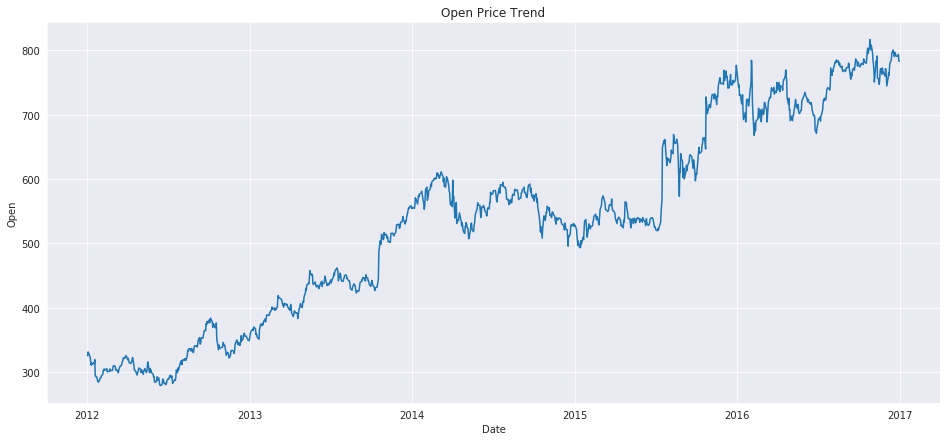

In [19]:
sea.lineplot(data = train_dataset, x = train_dataset.Date, y = train_dataset.Open)
plt.title('Open Price Trend')

### SMA Returns

In [31]:
train_dataset['Day_per_change'] = train_dataset.Open.pct_change()*100

In [33]:
train_dataset[:10]

,Date,Open,High,Low,Close,Volume,Day_per_change
0,2012-01-03,325.25,332.83,324.97,663.59,"7,380,500",NaN
1,2012-01-04,331.27,333.87,329.08,666.45,"5,749,400",1.850884
2,2012-01-05,329.83,330.75,326.89,657.21,"6,590,300",-0.434691
3,2012-01-06,328.34,328.77,323.68,648.24,"5,405,900",-0.451748
4,2012-01-09,322.04,322.29,309.46,620.76,"11,688,800",-1.918743
5,2012-01-10,313.70,315.72,307.30,621.43,"8,824,000",-2.589740
6,2012-01-11,310.59,313.52,309.40,624.25,"4,817,800",-0.991393
7,2012-01-12,314.43,315.26,312.08,627.92,"3,764,400",1.236357
8,2012-01-13,311.96,312.30,309.37,623.28,"4,631,800",-0.785548
9,2012-01-17,314.81,314.81,311.67,626.86,"3,832,800",0.913579


In [34]:
SMA = train_dataset.Day_per_change.rolling(7).mean()

[Text(0, 0.5, '% Returns'),
 Text(0.5, 0, 'Dates'),
 Text(0.5, 1.0, 'SMA Returns weekly between 2012 - 2013')]

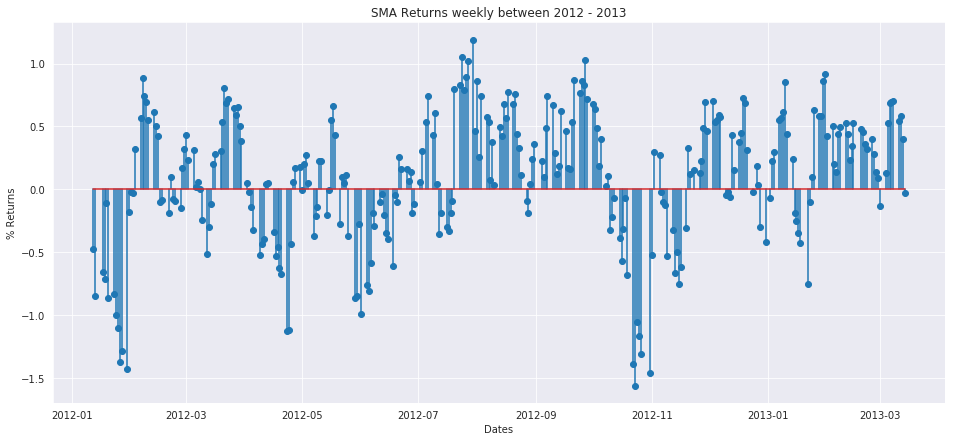

In [48]:
plt.stem(train_dataset.Date[7:300], SMA[7:300])
plt.gca().set(xlabel = 'Dates', ylabel = '% Returns', title = 'SMA Returns weekly between 2012 - 2013')

### Bollinger Analysis

In [41]:
train_dataset['mid_band'] = train_dataset.Open.rolling(14).mean()

In [43]:
train_dataset['upper_band'] = train_dataset.mid_band + 2*train_dataset.Open.rolling(14).std()
train_dataset['lower_band'] = train_dataset.mid_band - 2*train_dataset.Open.rolling(14).std()

[Text(0, 0.5, 'Stock price Movement'),
 Text(0.5, 0, 'Dates'),
 Text(0.5, 1.0, 'Bollinger Analysis')]

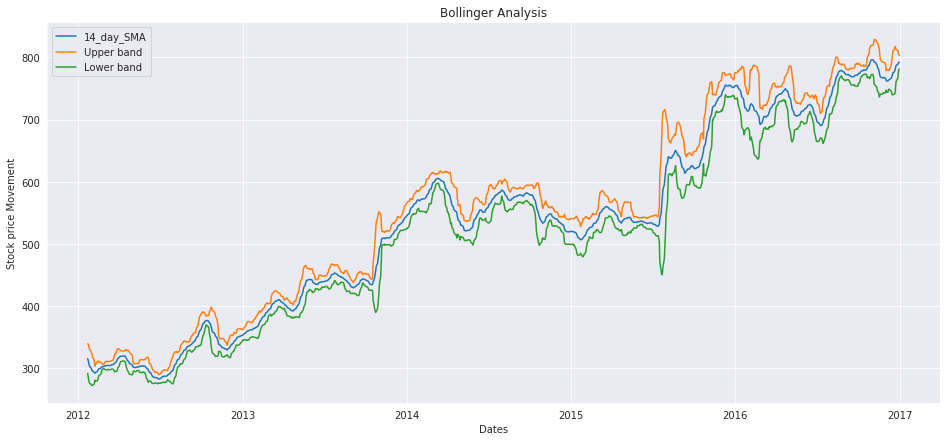

In [47]:
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.mid_band[13:], label = '14_day_SMA')
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.upper_band[13:], label = 'Upper band')
sea.lineplot(x=train_dataset.Date[13:], y =train_dataset.lower_band[13:], label = 'Lower band')
plt.gca().set(xlabel = 'Dates', ylabel = 'Stock price Movement', title = 'Bollinger Analysis')

Inference : The volatility of the stock tends to be quite low, thus, a safer option for any stock portfolio. Also, there are very few divergence and generally the bands are well squished 

### Preprocessing the data to be compatible with stacked arhitecture

Choosing the open price as a vector input

In [50]:
train_set = train_dataset.iloc[:,1:2].values

As, normalization works better while capturing stock movements, thus using it.

In [51]:
sc = MinMaxScaler(feature_range=(0, 1))
scaled_train_set = sc.fit_transform(train_set)

Creating a data-structure with 60 timesteps and 1 output. In general, this means the model will look back upon the last 60 observations and likewise operate the FMO valves in LSTMs.

In [52]:
x_train = []
y_train = []

In [53]:
for i in range(60, 1258):
    x_train.append(scaled_train_set[i-60 : i, 0])
    y_train.append(scaled_train_set[i, 0])

In [54]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [55]:
# Reshape for keras
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### RNN Model

In [56]:
RNNregressor = Sequential()

First LSTM layer

In [57]:
RNNregressor.add(LSTM(units=50, return_sequences=True, input_shape = ( x_train.shape[1], 1)))
RNNregressor.add(Dropout(rate=0.2))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Second LSTM layer

In [58]:
RNNregressor.add(LSTM(units=50, return_sequences=True))
RNNregressor.add(Dropout(rate=0.2))

Third LSTM layer

In [59]:
RNNregressor.add(LSTM(units=50, return_sequences=True))
RNNregressor.add(Dropout(rate=0.2))

Fourth LSTM layer

In [60]:
RNNregressor.add(LSTM(units=50))
RNNregressor.add(Dropout(rate=0.2))

Wrec doesn't need to move any further, thus, return sequences set to False

In [62]:
RNNregressor.add(Dense(1))
RNNregressor.compile(optimizer='adam', loss='mean_squared_error')

RMSprop also a good alternative

In [63]:
RNNregressor.fit(x_train, y_train, epochs= 100, batch_size= 32 )

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1198/1198 [==============================] - 29s 24ms/step - loss: 0.0727
Epoch 2/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0063
Epoch 3/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0058
Epoch 4/100
1198/1198 [==============================] - 31s 26ms/step - loss: 0.0050
Epoch 5/100
1198/1198 [==============================] - 30s 25ms/step - loss: 0.0051
Epoch 6/100
1198/1198 [==============================] - 26s 22ms/step - loss: 0.0046
Epoch 7/100
1198/1198 [==============================] - 26s 22ms/step - loss: 0.0046
Epoch 8/100
1198/1198 [==============================] - 22s 18ms/step - loss: 0.0042
Epoch 9/100
1198/1198 [==============================] - 20s 17ms/step - loss: 0.0041
Epoch 10/100
1198/1198 [==============================] - 25s 21ms/step - loss: 0.0041
Epoch 11/100
1198/1198 [==============================] - 27s 22ms/step - loss: 0.0042
Epoc

1198/1198 [==============================] - 17s 14ms/step - loss: 0.0014
Epoch 93/100
1198/1198 [==============================] - 19s 16ms/step - loss: 0.0013
Epoch 94/100
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0014
Epoch 95/100
1198/1198 [==============================] - 23s 19ms/step - loss: 0.0014
Epoch 96/100
1198/1198 [==============================] - 22s 18ms/step - loss: 0.0014
Epoch 97/100
1198/1198 [==============================] - 17s 14ms/step - loss: 0.0014
Epoch 98/100
1198/1198 [==============================] - 16s 13ms/step - loss: 0.0012
Epoch 99/100
1198/1198 [==============================] - 16s 14ms/step - loss: 0.0013
Epoch 100/100
1198/1198 [==============================] - 18s 15ms/step - loss: 0.0013


### Predicting Stock Prices of January 2017

In [64]:
test_dataset = pd.read_csv('./Google_Stock_Price_Test.csv')
real_stock_price = test_dataset.iloc[:, 1:2].values

In [65]:
dataset_total = pd.concat((train_dataset.Open, test_dataset.Open), axis = 0)
inputs = dataset_total[len(dataset_total)-len(test_dataset) - 60 :].values

In [66]:
inputs = inputs.reshape(-1,1)

In [67]:
inputs = sc.transform(inputs)

In [68]:
x_test = []
for i in range(60, 80):
    x_test.append(inputs[i-60 : i, 0])
    
x_test = np.array(x_test)

In [70]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))    

In [71]:
predicted_stock_price = RNNregressor.predict(x_test)

In [72]:
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [87]:
test_dataset.Date = pd.to_datetime(test_dataset.Date)

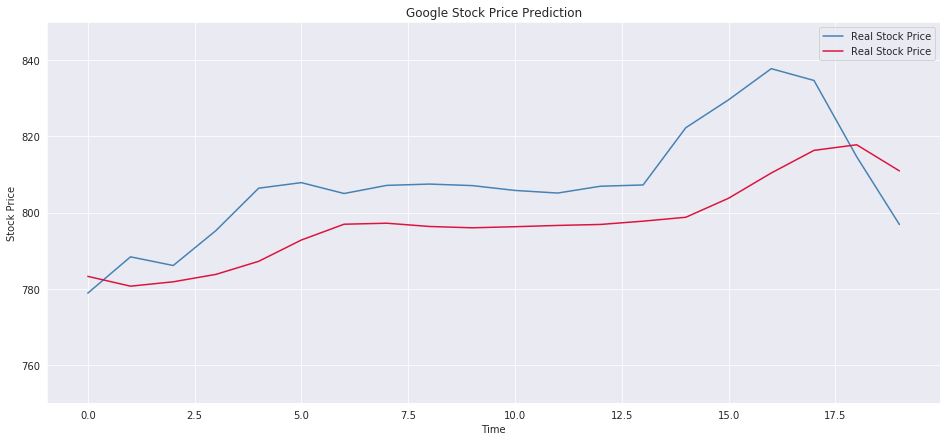

In [106]:
plt.ylim(750,850)
plt.plot(real_stock_price, color = 'steelblue', label = 'Real Stock Price')
plt.plot(predicted_stock_price, color = 'Crimson', label = 'Real Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
